We are trying to predict data traffic movement from nearby cells 


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, GRU, Conv1D, Dropout, GlobalAvgPool1D, MaxPool1D
from sklearn.preprocessing import MinMaxScaler

,1ALTE,1BLTE,1CLTE,2ALTE,3ALTE,3BLTE,3CLTE,4ALTE,4BLTE,4CLTE,5ALTE,5BLTE,5CLTE
1ALTE,1.000000,0.270262,0.159466,0.088597,0.313846,0.152227,0.317344,0.271379,0.453701,0.162706,0.323942,0.419159,0.427966
1BLTE,0.270262,1.000000,0.289001,0.059541,0.206337,0.168471,0.259509,0.247286,0.322760,0.180760,0.183910,0.241215,0.263671
1CLTE,0.159466,0.289001,1.000000,0.042606,0.153863,0.136920,0.187841,0.233094,0.302170,0.225566,0.129204,0.130734,0.235173
2ALTE,0.088597,0.059541,0.042606,1.000000,0.125897,0.027990,0.091462,0.040725,0.100747,0.016311,0.078260,0.091147,0.071682
3ALTE,0.313846,0.206337,0.153863,0.125897,1.000000,0.134527,0.299942,0.114832,0.269962,0.063910,0.366653,0.453106,0.411989
3BLTE,0.152227,0.168471,0.136920,0.027990,0.134527,1.000000,0.123067,0.107378,0.194226,0.118421,0.167428,0.173264,0.174866
3CLTE,0.317344,0.259509,0.187841,0.091462,0.299942,0.123067,1.000000,0.201062,0.369978,0.133845,0.259606,0.328446,0.335008
4ALTE,0.271379,0.247286,0.233094,0.040725,0.114832,0.107378,0.201062,1.000000,0.286555,0.136955,0.101272,0.138097,0.195666
4BLTE,0.453701,0.322760,0.302170,0.100747,0.269962,0.194226,0.369978,0.286555,1.000000,0.219111,0.302609,0.374218,0.431911
4CLTE,0.162706,0.180760,0.225566,0.016311,0.063910,0.118421,0.133845,0.136955,0.219111,1.000000,0.101010,0.096002,0.120033


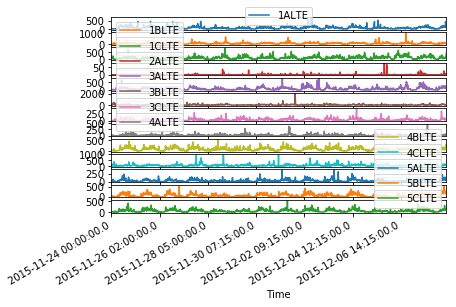

In [122]:
df = pd.read_csv("dataset.csv", index_col=0)
df = df.dropna()
df.head()
df.plot(subplots=True)
df.corr()

We have a multivariate timeseries classification problem. We need to structure it.

In [123]:
def split_sequences(sequences, n_steps):
    X, y, target = list(), list(), list()
    seq_target = list()
    for i in range(len(sequences)):
        # find the end of the subsequence
        end_ix = i + n_steps
        #check if we are past the dataset
        if end_ix > len(sequences) - 1:
            break
        # gather input and output parts of the subsequences
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        seq_target = np.where(seq_x[-1]<seq_y, 1, 0)   
        target.append(seq_target)    
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(target)

In [124]:
scaler = MinMaxScaler()
series = scaler.fit_transform(df.values)
X, y = split_sequences(series, 32)
X = X[:-200,:,:]
X.shape

(1158, 32, 13)

In [125]:
# here we choose wih cell
y = y[:-200,8]
y = y.astype('float')
# For GRU
#X = X.reshape(X.shape[0], X.shape[1], 1)

In [150]:
def create_model():
    inputs = Input(shape=X.shape[1:])
    x = Flatten()(inputs)
    x = Dense(512, activity_regularizer='l2', activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(2, activation='softmax')(x)
    mlp = Model(inputs ,out)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return mlp


In [136]:
history = mlp.fit(X, y, epochs=50, validation_split=0.2)

Train on 926 samples, validate on 232 samples
Epoch 1/50
926/926 [==============================] - 1s 1ms/step - loss: 0.7730 - acc: 0.5151 - val_loss: 0.6942 - val_acc: 0.4914
Epoch 2/50
926/926 [==============================] - 0s 88us/step - loss: 0.6930 - acc: 0.5302 - val_loss: 0.6940 - val_acc: 0.4957
Epoch 3/50
926/926 [==============================] - 0s 86us/step - loss: 0.6927 - acc: 0.5248 - val_loss: 0.6945 - val_acc: 0.4612
Epoch 4/50
926/926 [==============================] - 0s 90us/step - loss: 0.6922 - acc: 0.5432 - val_loss: 0.6953 - val_acc: 0.4828
Epoch 5/50
926/926 [==============================] - 0s 89us/step - loss: 0.6914 - acc: 0.5572 - val_loss: 0.6954 - val_acc: 0.5043
Epoch 6/50
926/926 [==============================] - 0s 104us/step - loss: 0.6896 - acc: 0.5799 - val_loss: 0.6962 - val_acc: 0.4871
Epoch 7/50
926/926 [==============================] - 0s 125us/step - loss: 0.6881 - acc: 0.5950 - val_loss: 0.6966 - val_acc: 0.4784
Epoch 8/50
926/926 [==

In [161]:
#Kfold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


kf = KFold(n_splits=10)
#for train_index, test_index in kf.split(X):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    mlp.fit(X_train, y_train, epochs = 10)

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=64, verbose=0)

scores = cross_val_score(model, X, y, cv=kf)

avg_score = np.mean(scores)
print(avg_score)

0.5846326898956584


In [119]:
inputs = Input(shape=X.shape[1:])
x = GRU(256)(inputs)
out = Dense(2, activation='softmax')(x)
lstm = Model(inputs ,out)
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(X, y, epochs=50, validation_split=0.2)



Train on 926 samples, validate on 232 samples
Epoch 1/50
926/926 [==============================] - 3s 4ms/step - loss: 0.6909 - acc: 0.5162 - val_loss: 0.6848 - val_acc: 0.5776
Epoch 2/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6820 - acc: 0.5583 - val_loss: 0.6825 - val_acc: 0.5905
Epoch 3/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6704 - acc: 0.6253 - val_loss: 0.6714 - val_acc: 0.6164
Epoch 4/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6598 - acc: 0.6242 - val_loss: 0.6646 - val_acc: 0.5991
Epoch 5/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6460 - acc: 0.6458 - val_loss: 0.6548 - val_acc: 0.6207
Epoch 6/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6307 - acc: 0.6674 - val_loss: 0.6430 - val_acc: 0.6379
Epoch 7/50
926/926 [==============================] - 2s 2ms/step - loss: 0.6121 - acc: 0.6749 - val_loss: 0.6416 - val_acc: 0.6078
Epoch 8/50
926/926 [==========

In [120]:
inputs = Input(shape=X.shape[1:])
x = Conv1D(64, 2, activation='relu', )(inputs)
x = MaxPool1D(2)(x)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
out = Dense(2, activation='softmax')(x)
lstm = Model(inputs ,out)
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(X, y, epochs=50, validation_split=0.2)


Train on 926 samples, validate on 232 samples
Epoch 1/50
926/926 [==============================] - 1s 2ms/step - loss: 0.6991 - acc: 0.4924 - val_loss: 0.6945 - val_acc: 0.4871
Epoch 2/50
926/926 [==============================] - 0s 121us/step - loss: 0.6907 - acc: 0.5486 - val_loss: 0.6957 - val_acc: 0.5086
Epoch 3/50
926/926 [==============================] - 0s 121us/step - loss: 0.6861 - acc: 0.5529 - val_loss: 0.6954 - val_acc: 0.5043
Epoch 4/50
926/926 [==============================] - 0s 115us/step - loss: 0.6812 - acc: 0.5605 - val_loss: 0.6973 - val_acc: 0.4784
Epoch 5/50
926/926 [==============================] - 0s 122us/step - loss: 0.6780 - acc: 0.5691 - val_loss: 0.7019 - val_acc: 0.5000
Epoch 6/50
926/926 [==============================] - 0s 140us/step - loss: 0.6724 - acc: 0.5734 - val_loss: 0.6985 - val_acc: 0.4655
Epoch 7/50
926/926 [==============================] - 0s 113us/step - loss: 0.6608 - acc: 0.6166 - val_loss: 0.6976 - val_acc: 0.5302
Epoch 8/50
926/926